# Spatial Hotspot Analysis - Crime Clustering

This notebook implements the primary clustering analysis for geographic crime hotspot identification. Using density-based and partitioning algorithms, we identify spatial crime concentration patterns in NYC data.

## Objectives
- Detect crime hotspots using DBSCAN for density-based spatial clustering
- Identify geographic crime zones using K-means clustering  
- Compare HDBSCAN for varying density hotspot detection
- Integrate temporal patterns for comprehensive hotspot analysis
- Build production-ready pipelines for operational deployment

**Dependencies:**
- Preprocessed crime dataset with spatial-temporal features
- Custom clustering transformers from `clustering_transformers.py`
- Geographic coordinate validation and feature completeness

---

# 1. Setup

This section handles the initial setup, including importing necessary libraries, defining file paths, and configuring the environment for spatial clustering analysis. Custom transformers for spatial feature engineering are imported from our utilities module.

## Optional: Google Colab Setup

Uncomment and run this cell if working in Google Colab environment.

In [2]:
# Run on Google Colab (optional)
# from google.colab import drive
# drive.mount('/drive', force_remount=True)

## Import Libraries

Import all libraries required for spatial clustering analysis, pipeline construction, and geographic visualization.

In [3]:
# Core data manipulation and computation
import pandas as pd
import numpy as np
import os
import sys
import warnings
import joblib
import json
from typing import Dict, List, Tuple, Optional, Any

# Machine learning and clustering
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Geographic and mapping libraries
try:
    import folium
    from folium import plugins
    FOLIUM_AVAILABLE = True
except ImportError:
    print("Folium not available. Map visualizations will be limited.")
    FOLIUM_AVAILABLE = False

# Geographic projection libraries for metric coordinate transformation
# These are crucial for DBSCAN/HDBSCAN to work properly with spatial data
try:
    import pyproj
    print("✓ pyproj available for high-accuracy coordinate projection")
    PYPROJ_AVAILABLE = True
except ImportError:
    print("⚠ pyproj not available. Will use fallback projection methods.")
    PYPROJ_AVAILABLE = False

try:
    import utm
    print("✓ UTM library available for coordinate projection")
    UTM_AVAILABLE = True
except ImportError:
    print("⚠ UTM library not available. Will use approximation methods.")
    UTM_AVAILABLE = False

# Install projection libraries if needed
if not PYPROJ_AVAILABLE and not UTM_AVAILABLE:
    print("\n" + "="*60)
    print("COORDINATE PROJECTION SETUP")
    print("="*60)
    print("For optimal DBSCAN/HDBSCAN performance, we recommend installing:")
    print("pip install pyproj utm")
    print("\nFalling back to approximation method for now...")
    print("="*60)

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

✓ pyproj available for high-accuracy coordinate projection
✓ UTM library available for coordinate projection


In [4]:
# Install coordinate projection libraries for accurate DBSCAN/HDBSCAN clustering
# These libraries are essential for converting lat/lon to metric coordinates

print("="*60)
print("COORDINATE PROJECTION LIBRARIES SETUP")
print("="*60)

# Check if libraries are already installed
libraries_to_install = []

try:
    import pyproj
    print("✓ pyproj already installed (high-accuracy projections)")
except ImportError:
    libraries_to_install.append("pyproj")
    print("⚠ pyproj not found - will install for high-accuracy projections")

try:
    import utm
    print("✓ utm already installed (simple UTM projections)")
except ImportError:
    libraries_to_install.append("utm")
    print("⚠ utm not found - will install for UTM projections")

# Install missing libraries
if libraries_to_install:
    print(f"\nInstalling missing libraries: {', '.join(libraries_to_install)}")
    print("This is crucial for proper DBSCAN/HDBSCAN distance calculations!")
    
    import subprocess
    import sys
    
    for library in libraries_to_install:
        try:
            print(f"Installing {library}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", library, "--quiet"])
            print(f"✓ {library} installed successfully")
        except subprocess.CalledProcessError as e:
            print(f"⚠ Failed to install {library}: {e}")
            print(f"Manual installation: pip install {library}")
    
    print("\nRestarting kernel may be required for new imports to work properly.")
else:
    print("✓ All coordinate projection libraries are available!")

print("="*60)

COORDINATE PROJECTION LIBRARIES SETUP
✓ pyproj already installed (high-accuracy projections)
✓ utm already installed (simple UTM projections)
✓ All coordinate projection libraries are available!


## Configure Paths and Custom Utilities

Set up file paths and import custom clustering utilities.

In [5]:
# Configure working directory and paths
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '../..'))
data_dir = os.path.join(project_root, 'Data')
output_dir = os.path.join(project_root, 'JupyterOutputs', 'Clustering')
models_dir = os.path.join(output_dir, 'models')

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")
print(f"Models directory: {models_dir}")

# Add utilities to Python path
utilities_path = os.path.join(os.getcwd(), 'Utilities')
if utilities_path not in sys.path:
    sys.path.append(utilities_path)

# Import custom clustering utilities with reload for updated functions
try:
    import clustering_transformers
    import importlib
    importlib.reload(clustering_transformers)  # Reload to get updated functions
    
    print("✓ Custom clustering transformers imported successfully!")
    print("✓ SpatialProjectionTransformer available for coordinate projection")
except ImportError as e:
    print(f"Warning: Could not import custom transformers: {e}")
    print("Please ensure clustering_transformers.py is in the Utilities folder.")
    # Define fallback minimal functionality
    print("Will use basic sklearn functionality as fallback")

Project root: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer
Data directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\Data
Output directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering
Models directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering\models
✓ Custom clustering transformers imported successfully!
✓ SpatialProjectionTransformer available for coordinate projection


## Configure Analysis Parameters

Define key parameters for the spatial clustering analysis.

In [6]:
# Random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Spatial clustering parameters (following standard literature approach)
# For spatial clustering, we use projected coordinates in meters WITHOUT standardization
# This maintains interpretability: eps=200 means 200 meters radius
SPATIAL_CONFIG = {
    'dbscan': {
        # Epsilon values in meters (for raw projected coordinates)
        # Based on literature: typical urban hotspot radii 50m-500m
        'eps_range': [50, 100, 200, 300, 500],  # 50m to 500m radius for hotspots
        'min_samples_range': [5, 10, 15, 20, 25],
        'default_eps': 200,  # 200m default radius
        'default_min_samples': 10
    },
    'hdbscan': {
        'min_cluster_size_range': [25, 50, 75, 100],
        'default_min_cluster_size': 50
    },
    'kmeans': {
        'n_clusters_range': [5, 8, 10, 12, 15],
        'default_n_clusters': 8
    }
}

# Coordinate projection configuration
PROJECTION_CONFIG = {
    'method': 'auto',  # 'auto', 'utm', 'mercator', 'approximation'
    'utm_zone': 18,    # NYC is in UTM zone 18N
    'utm_hemisphere': 'north'
}

# Feature columns for spatial analysis (aligned with actual dataset)
SPATIAL_FEATURES = ['Latitude', 'Longitude']

# Primary temporal features for clustering
TEMPORAL_FEATURES = ['HOUR', 'WEEKDAY', 'MONTH']

# Extended temporal features available in dataset
EXTENDED_TEMPORAL_FEATURES = [
    'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR', 
    'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY'
]

# Categorical features (using actual column names from dataset)
CATEGORICAL_FEATURES = ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC']

# Extended categorical features available
EXTENDED_CATEGORICAL_FEATURES = [
    'BORO_NM', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PREM_TYP_DESC',
    'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'
]

# Spatial context features (POI-based features for enhanced spatial analysis)
SPATIAL_CONTEXT_FEATURES = [
    'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'METRO_DISTANCE',
    'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE',
    'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 
    'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'TOTAL_POI_COUNT',
    'POI_DIVERSITY', 'POI_DENSITY_SCORE'
]

# Social features 
SOCIAL_FEATURES = ['SAME_AGE_GROUP', 'SAME_SEX']

# Validation thresholds (updated for metric coordinates)
VALIDATION_THRESHOLDS = {
    'min_silhouette_score': 0.3,
    'max_noise_ratio': 0.5,  # Increased tolerance for urban crime data
    'min_clusters': 2,
    'max_clusters': 50
}

print("Analysis parameters configured successfully!")
print(f"Primary spatial features: {SPATIAL_FEATURES}")
print(f"Primary temporal features: {TEMPORAL_FEATURES}")
print(f"Primary categorical features: {CATEGORICAL_FEATURES}")
print(f"Projection configuration: {PROJECTION_CONFIG}")
print(f"DBSCAN eps range (meters): {SPATIAL_CONFIG['dbscan']['eps_range']}")
print(f"Available spatial context features: {len(SPATIAL_CONTEXT_FEATURES)} POI-based features")
print(f"Available extended temporal features: {len(EXTENDED_TEMPORAL_FEATURES)} temporal features")
print(f"Validation thresholds: {VALIDATION_THRESHOLDS}")
print("\n" + "="*60)
print("SPATIAL CLUSTERING BEST PRACTICE")
print("="*60)
print("Following standard literature approach for spatial clustering:")
print("✓ Use projected coordinates in meters (UTM/Mercator)")
print("✓ NO standardization for spatial features")
print("✓ Epsilon parameters directly interpretable in meters")
print("✓ Example: eps=200 means 200-meter radius hotspots")
print("✓ This maintains geographic interpretability and domain knowledge")
print("="*60)

Analysis parameters configured successfully!
Primary spatial features: ['Latitude', 'Longitude']
Primary temporal features: ['HOUR', 'WEEKDAY', 'MONTH']
Primary categorical features: ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC']
Projection configuration: {'method': 'auto', 'utm_zone': 18, 'utm_hemisphere': 'north'}
DBSCAN eps range (meters): [50, 100, 200, 300, 500]
Available spatial context features: 16 POI-based features
Available extended temporal features: 10 temporal features
Validation thresholds: {'min_silhouette_score': 0.3, 'max_noise_ratio': 0.5, 'min_clusters': 2, 'max_clusters': 50}

SPATIAL CLUSTERING BEST PRACTICE
Following standard literature approach for spatial clustering:
✓ Use projected coordinates in meters (UTM/Mercator)
✓ NO standardization for spatial features
✓ Epsilon parameters directly interpretable in meters
✓ Example: eps=200 means 200-meter radius hotspots
✓ This maintains geographic interpretability and domain knowledge


---

# 2. Data Loading & Feature Preparation

This section loads the preprocessed crime dataset and prepares features specifically for spatial clustering analysis. We validate coordinate accuracy, assess feature completeness, and prepare the data for various clustering algorithms.

## Load Preprocessed Crime Dataset

Load and validate the preprocessed crime data with spatial-temporal features.

In [7]:
# Define data file path
data_file = os.path.join(data_dir, 'final_crime_data.csv')

# Check if data file exists
if not os.path.exists(data_file):
    raise FileNotFoundError(f"Data file not found: {data_file}")

print(f"Loading data from: {data_file}")

# Load the dataset
try:
    df = pd.read_csv(data_file)
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")

# Display basic dataset information
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total records: {len(df):,}")
print(f"Total features: {df.shape[1]}")

Loading data from: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\Data\final_crime_data.csv
Dataset loaded successfully!
Shape: (2493835, 44)
Memory usage: 2453.35 MB

DATASET OVERVIEW
Total records: 2,493,835
Total features: 44


## Data Quality Assessment

Perform comprehensive data quality assessment focusing on spatial-temporal features.

In [8]:
# Check for missing values in key features
print("\n" + "="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Missing values analysis
missing_analysis = df.isnull().sum()
missing_pct = (missing_analysis / len(df)) * 100

print("Missing values analysis:")
print("-" * 30)
for col in df.columns:
    if missing_analysis[col] > 0:
        print(f"{col}: {missing_analysis[col]:,} ({missing_pct[col]:.2f}%)")

# Focus on spatial features
if all(col in df.columns for col in SPATIAL_FEATURES):
    print(f"\nSpatial features status:")
    print("-" * 30)
    for col in SPATIAL_FEATURES:
        valid_coords = df[col].notna()
        print(f"{col}: {valid_coords.sum():,} valid ({(valid_coords.sum()/len(df))*100:.2f}%)")
    
    # Check coordinate ranges (NYC boundaries) - use actual column names
    lat_col = 'Latitude'  # Actual column name in dataset
    lon_col = 'Longitude'  # Actual column name in dataset
    
    lat_range = (df[lat_col].min(), df[lat_col].max())
    lon_range = (df[lon_col].min(), df[lon_col].max())
    
    print(f"\nCoordinate ranges:")
    print(f"{lat_col}: {lat_range[0]:.6f} to {lat_range[1]:.6f}")
    print(f"{lon_col}: {lon_range[0]:.6f} to {lon_range[1]:.6f}")
    
    # NYC approximate boundaries check
    nyc_lat_bounds = (40.4774, 40.9176)
    nyc_lon_bounds = (-74.2591, -73.7004)
    
    lat_in_bounds = df[lat_col].between(nyc_lat_bounds[0], nyc_lat_bounds[1]).sum()
    lon_in_bounds = df[lon_col].between(nyc_lon_bounds[0], nyc_lon_bounds[1]).sum()
    
    print(f"\nNYC boundary validation:")
    print(f"{lat_col} in NYC bounds: {lat_in_bounds:,} ({(lat_in_bounds/len(df))*100:.2f}%)")
    print(f"{lon_col} in NYC bounds: {lon_in_bounds:,} ({(lon_in_bounds/len(df))*100:.2f}%)")
else:
    print("Warning: Required spatial features not found in dataset")
    print(f"Available columns: {list(df.columns)}")
    print(f"Missing spatial features: {[col for col in SPATIAL_FEATURES if col not in df.columns]}")


DATA QUALITY ASSESSMENT
Missing values analysis:
------------------------------

Spatial features status:
------------------------------
Latitude: 2,493,835 valid (100.00%)
Longitude: 2,493,835 valid (100.00%)

Coordinate ranges:
Latitude: 40.498896 to 40.912714
Longitude: -74.254741 to -73.700286

NYC boundary validation:
Latitude in NYC bounds: 2,493,835 (100.00%)
Longitude in NYC bounds: 2,493,832 (100.00%)


## Feature Selection and Validation

Select and validate features for spatial clustering analysis.

In [9]:
# Validate feature availability
print("\n" + "="*60)
print("FEATURE VALIDATION")
print("="*60)

# Check spatial features
spatial_available = [col for col in SPATIAL_FEATURES if col in df.columns]
temporal_available = [col for col in TEMPORAL_FEATURES if col in df.columns]
categorical_available = [col for col in CATEGORICAL_FEATURES if col in df.columns]

print("Feature availability:")
print("-" * 30)
print(f"Spatial features: {spatial_available} ({len(spatial_available)}/{len(SPATIAL_FEATURES)})")
print(f"Temporal features: {temporal_available} ({len(temporal_available)}/{len(TEMPORAL_FEATURES)})")
print(f"Categorical features: {categorical_available} ({len(categorical_available)}/{len(CATEGORICAL_FEATURES)})")

# Apply the same temporal filter as classification test set for consistency
print(f"\n" + "="*60)
print("TEMPORAL FILTERING FOR CLUSTERING")
print("="*60)

if 'YEAR' in df.columns and 'MONTH' in df.columns:
    print(f"Original dataset years: {sorted(df['YEAR'].unique())}")
    print(f"Total records before temporal filter: {len(df):,}")
    
    # Create YearMonth for consistent filtering with classification approach
    df['YearMonth'] = df['YEAR'] * 100 + df['MONTH']
    print(f"Year-Month distribution in original dataset:")
    ym_counts = df['YearMonth'].value_counts().sort_index()
    for ym, count in ym_counts.items():
        print(f"  {ym}: {count:,} records")
    
    # Use the same temporal split point as classification test set (YearMonth >= 202408)
    # This corresponds to the most recent data used in classification evaluation
    test_set_start_ym = 202408  # August 2024, same as classification
    print(f"\nFiltering for clustering analysis using classification test set period:")
    print(f"Using YearMonth >= {test_set_start_ym} (same as classification test set)")
    
    # Apply filter - using the classification test set period
    df_filtered = df[df['YearMonth'] >= test_set_start_ym].copy()
    
    print(f"Records after temporal filter: {len(df_filtered):,} ({(len(df_filtered)/len(df))*100:.1f}% of original)")
    
    if len(df_filtered) > 0:
        print(f"Filtered dataset year-months:")
        filtered_ym_counts = df_filtered['YearMonth'].value_counts().sort_index()
        for ym, count in filtered_ym_counts.items():
            print(f"  {ym}: {count:,} records")
        
        # Drop the temporary YearMonth column
        df_filtered.drop(columns=['YearMonth'], inplace=True)
        df.drop(columns=['YearMonth'], inplace=True)
        
        # Use filtered data for clustering
        df = df_filtered
        print(f"\nUsing filtered dataset for clustering analysis.")
        print(f"This approach ensures consistency with classification methodology")
        print(f"and focuses on the most recent crime patterns.")
    else:
        print(f"Warning: No data found for YearMonth >= {test_set_start_ym}")
        print("Falling back to recent years filter (YEAR >= 2023)")
        # Fallback to the previous approach
        recent_years_threshold = 2023
        df_filtered = df[df['YEAR'] >= recent_years_threshold].copy()
        df = df_filtered
        df.drop(columns=['YearMonth'], inplace=True)
else:
    print("Warning: YEAR or MONTH column not found. Skipping temporal filtering.")
    print("Using full dataset for clustering analysis.")

# Create clean dataset for spatial analysis
print(f"\nPreparing dataset for spatial clustering...")

# Filter for valid coordinates
if len(spatial_available) >= 2:
    # Remove rows with missing coordinates
    valid_coords_mask = df[spatial_available].notna().all(axis=1)
    df_spatial = df[valid_coords_mask].copy()
    
    print(f"Records with valid coordinates: {len(df_spatial):,} ({(len(df_spatial)/len(df))*100:.2f}%)")
    
    # Additional coordinate validation (remove obvious outliers) - use actual column names
    lat_col = 'Latitude'  # Actual column name
    lon_col = 'Longitude'  # Actual column name
    
    if lat_col in df_spatial.columns and lon_col in df_spatial.columns:
        # NYC coordinate bounds
        nyc_bounds_mask = (
            df_spatial[lat_col].between(40.4774, 40.9176) &
            df_spatial[lon_col].between(-74.2591, -73.7004)
        )
        df_spatial = df_spatial[nyc_bounds_mask].copy()
        
        print(f"Records within NYC bounds: {len(df_spatial):,}")
    else:
        print(f"Warning: Coordinate columns {lat_col}/{lon_col} not found for geographic filtering")
else:
    raise ValueError("Insufficient spatial features for clustering analysis")

# Display final dataset summary
print(f"\nFinal dataset for clustering:")
print(f"Shape: {df_spatial.shape}")
print(f"Coordinate coverage: {len(df_spatial):,} records")
print(f"Time range: {df_spatial['YEAR'].min()} - {df_spatial['YEAR'].max()}")
print(f"Memory usage: {df_spatial.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check availability of extended features
print(f"\nExtended features availability:")
print("-" * 40)

# Check spatial context features (POI-based)
spatial_context_available = [col for col in SPATIAL_CONTEXT_FEATURES if col in df.columns]
print(f"Spatial context features: {len(spatial_context_available)}/{len(SPATIAL_CONTEXT_FEATURES)} available")
if spatial_context_available:
    print(f"  Available: {spatial_context_available[:5]}...")  # Show first 5

# Check extended temporal features
extended_temporal_available = [col for col in EXTENDED_TEMPORAL_FEATURES if col in df.columns]
print(f"Extended temporal features: {len(extended_temporal_available)}/{len(EXTENDED_TEMPORAL_FEATURES)} available")
if extended_temporal_available:
    print(f"  Available: {extended_temporal_available}")

# Check extended categorical features
extended_categorical_available = [col for col in EXTENDED_CATEGORICAL_FEATURES if col in df.columns]
print(f"Extended categorical features: {len(extended_categorical_available)}/{len(EXTENDED_CATEGORICAL_FEATURES)} available")
if extended_categorical_available:
    print(f"  Available: {extended_categorical_available[:5]}...")  # Show first 5

# Check social features
social_available = [col for col in SOCIAL_FEATURES if col in df.columns]
print(f"Social features: {len(social_available)}/{len(SOCIAL_FEATURES)} available")
if social_available:
    print(f"  Available: {social_available}")

# Display temporal distribution after filtering
if 'YEAR' in df_spatial.columns and 'MONTH' in df_spatial.columns:
    print(f"\nTemporal distribution in filtered dataset:")
    print("-" * 40)
    yearly_counts = df_spatial['YEAR'].value_counts().sort_index()
    for year, count in yearly_counts.items():
        print(f"  {year}: {count:,} records")
    
    # Show monthly distribution for each year in the filtered data
    years_in_data = sorted(df_spatial['YEAR'].unique())
    for year in years_in_data:
        monthly_counts = df_spatial[df_spatial['YEAR'] == year]['MONTH'].value_counts().sort_index()
        print(f"\nMonthly distribution for {year}:")
        print("-" * 40)
        for month, count in monthly_counts.items():
            print(f"  Month {month:2d}: {count:,} records")

# Final clustering dataset summary
print(f"\n" + "="*60)
print("CLUSTERING DATASET SUMMARY")
print("="*60)
print(f"Dataset period: Same as classification test set (Aug 2024 onwards)")
print(f"Total records for clustering: {len(df_spatial):,}")
print(f"Data reduction: {((len(df_spatial)/len(df))*100):.1f}% of original dataset retained")
print(f"Temporal consistency: ✓ Matches classification evaluation period")
print(f"Geographic validity: ✓ NYC coordinate bounds enforced")
print(f"Ready for spatial hotspot clustering analysis!")


FEATURE VALIDATION
Feature availability:
------------------------------
Spatial features: ['Latitude', 'Longitude'] (2/2)
Temporal features: ['HOUR', 'WEEKDAY', 'MONTH'] (3/3)
Categorical features: ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC'] (3/3)

TEMPORAL FILTERING FOR CLUSTERING
Original dataset years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Total records before temporal filter: 2,493,835
Year-Month distribution in original dataset:
  202001: 38,695 records
  202002: 35,446 records
  202003: 32,679 records
  202004: 24,907 records
  202005: 32,023 records
  202006: 32,604 records
  202007: 35,531 records
  202008: 37,524 records
  202009: 35,983 records
  202010: 37,403 records
  202011: 35,148 records
  202012: 33,516 records
  202101: 33,217 records
  202102: 28,332 records
  202103: 34,612 records
  202104: 32,619 records
  202105: 36,711 records
  202106: 37,516 records
  202107: 39,402 records
  202108: 38,945 records
  202109: 39,906 rec

In [10]:
# --- Optional: Work on a smaller sample for faster iteration ---
# Do NOT overwrite df_spatial; create a lightweight subset instead.

N_SAMPLE = 100_000  # number of rows to take

# First N rows (deterministic, same each run)
df_spatial_sample = df_spatial.sample(N_SAMPLE).copy()

# OR (uncomment for random sample, new each run):
# df_spatial_sample = df_spatial.sample(n=N_SAMPLE, random_state=42).copy()

print(f"Sample created: {df_spatial_sample.shape[0]} rows out of {df_spatial.shape[0]} total")
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 44)
print(df_spatial_sample.head(1))


Sample created: 100000 rows out of 232368 total
        BORO_NM  KY_CD LAW_CAT_CD LOC_OF_OCCUR_DESC      OFNS_DESC  PD_CD  \
2070067   BRONX    578  VIOLATION            INSIDE  HARRASSMENT 2    638   

           PREM_TYP_DESC SUSP_AGE_GROUP SUSP_RACE SUSP_SEX VIC_AGE_GROUP  \
2070067  RESIDENCE-HOUSE          25-44     BLACK        F           65+   

        VIC_RACE VIC_SEX   Latitude  Longitude  BAR_DISTANCE  \
2070067    BLACK       F  40.887846 -73.855371   1464.539698   

         NIGHTCLUB_DISTANCE  ATM_DISTANCE  ATMS_COUNT  BARS_COUNT  \
2070067         4592.717703   2601.614358         0.0         0.0   

         BUS_STOPS_COUNT  METROS_COUNT  NIGHTCLUBS_COUNT  SCHOOLS_COUNT  \
2070067              0.0           0.0               0.0            0.0   

         METRO_DISTANCE  MIN_POI_DISTANCE  AVG_POI_DISTANCE  MAX_POI_DISTANCE  \
2070067      423.004471        423.004471       2270.469057       4592.717703   

         TOTAL_POI_COUNT  POI_DIVERSITY  POI_DENSITY_SCORE  HO

## 3. Spatio-Temporal DBSCAN Clustering


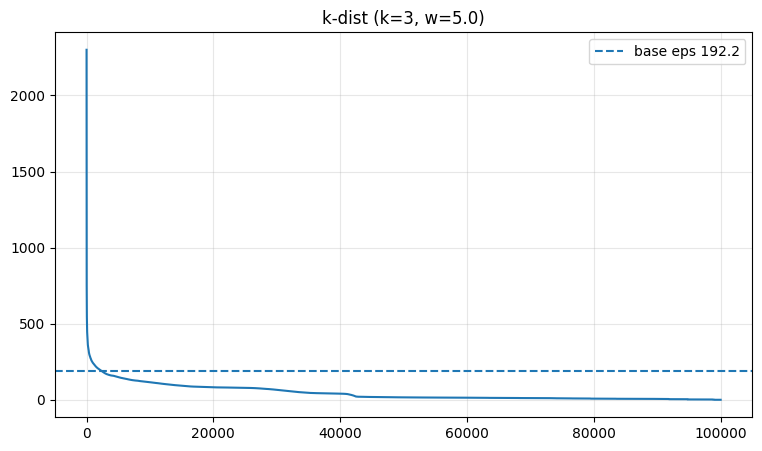

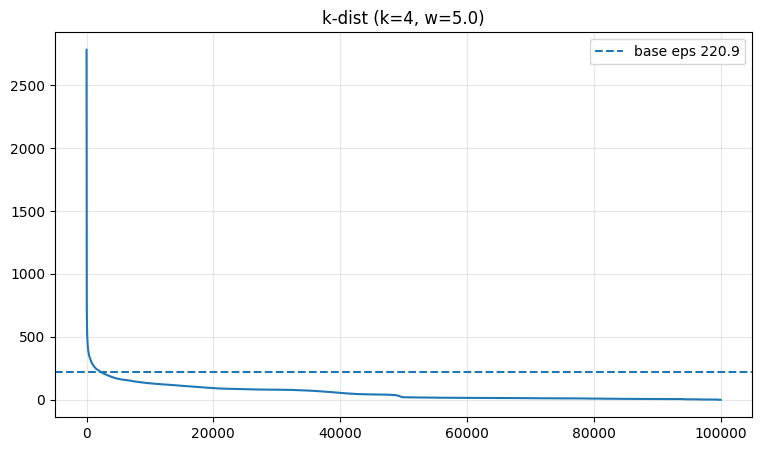

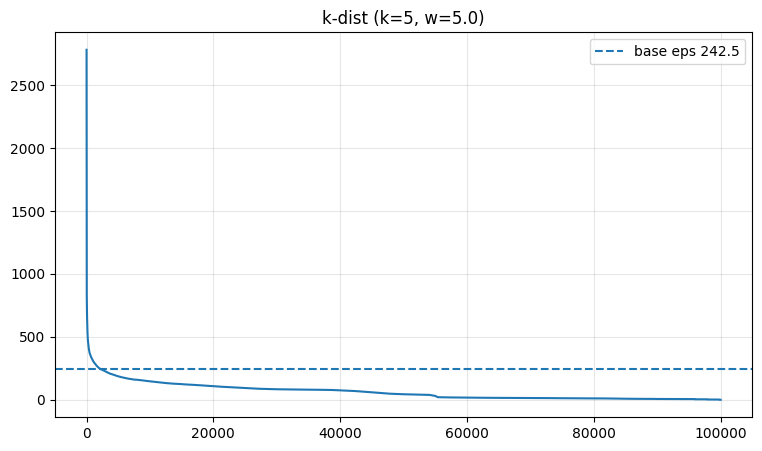

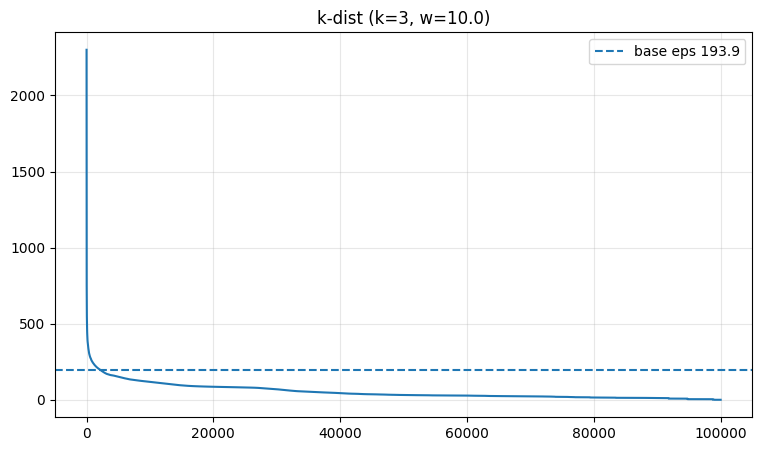

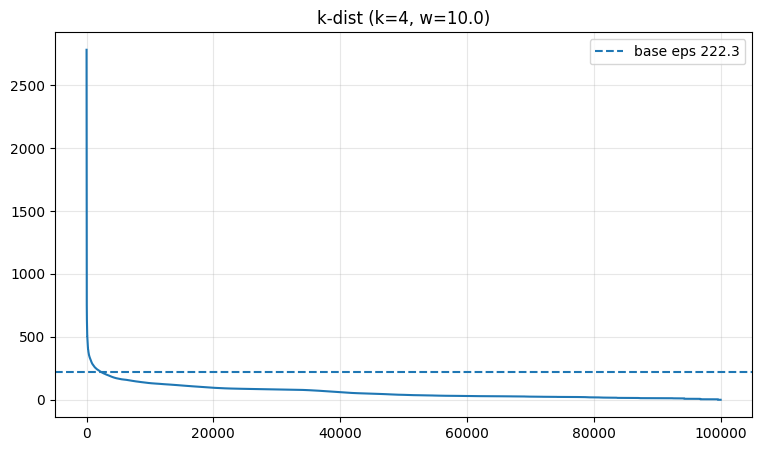

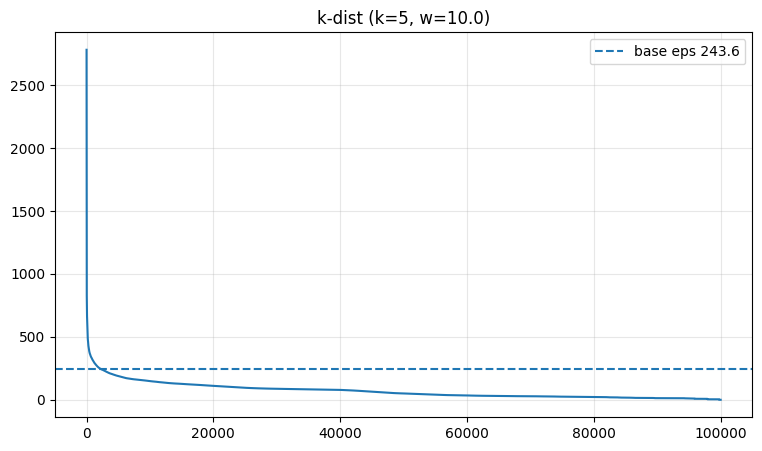

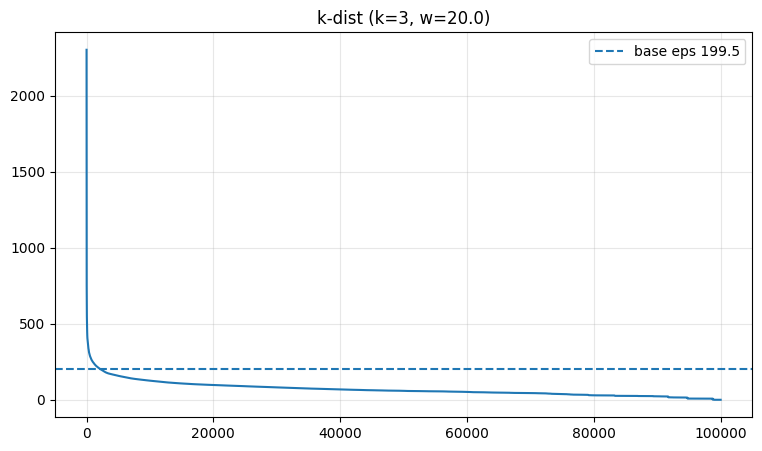

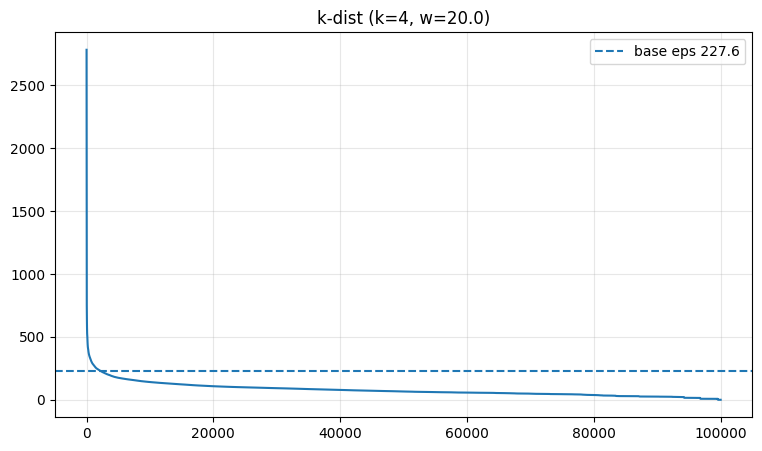

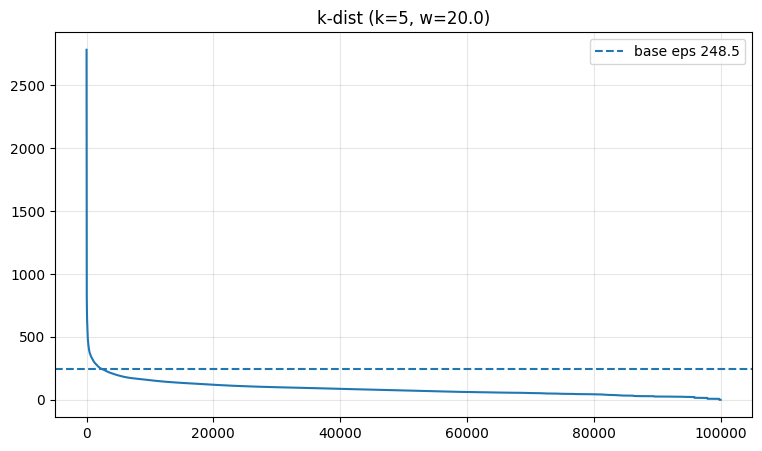

Testing: eps=57.6538, min_samples=3, temporal_weight=5.0
Testing: eps=96.0896, min_samples=3, temporal_weight=5.0
Testing: eps=134.525, min_samples=3, temporal_weight=5.0
Testing: eps=172.961, min_samples=3, temporal_weight=5.0
Testing: eps=192.179, min_samples=3, temporal_weight=5.0
Testing: eps=66.256, min_samples=4, temporal_weight=5.0
Testing: eps=110.427, min_samples=4, temporal_weight=5.0
Testing: eps=154.597, min_samples=4, temporal_weight=5.0
Testing: eps=198.768, min_samples=4, temporal_weight=5.0
Testing: eps=220.853, min_samples=4, temporal_weight=5.0
Testing: eps=72.7377, min_samples=5, temporal_weight=5.0
Testing: eps=121.229, min_samples=5, temporal_weight=5.0
Testing: eps=169.721, min_samples=5, temporal_weight=5.0
Testing: eps=218.213, min_samples=5, temporal_weight=5.0
Testing: eps=242.459, min_samples=5, temporal_weight=5.0
Testing: eps=58.1788, min_samples=3, temporal_weight=10.0
Testing: eps=96.9646, min_samples=3, temporal_weight=10.0
Testing: eps=135.75, min_sampl

,eps,min_samples,temporal_weight,n_clusters,noise_ratio,silhouette,runtime_s,avg_cluster_radius_m,median_cluster_radius_m
0,57.653756,3,5.0,8894,0.21460,0.607123,0.880497,9.737639,0.188906
1,66.256022,4,5.0,6117,0.27526,0.563586,2.249913,13.520086,0.226027
2,58.178769,3,10.0,8915,0.22052,0.538366,0.485110,9.174733,0.180804
3,72.737673,5,5.0,4487,0.31605,0.526353,0.477818,17.547549,0.501357
4,66.680519,4,10.0,6125,0.28203,0.506204,0.626101,12.814230,0.226016
5,73.075592,5,10.0,4478,0.32631,0.481157,0.992750,16.443957,0.421879
6,59.842601,3,20.0,7700,0.31676,0.468054,1.120048,5.721048,0.148689
7,68.278702,4,20.0,5665,0.33941,0.447861,1.107152,8.779134,0.204422
8,74.542870,5,20.0,4357,0.36821,0.431979,0.733045,12.297843,0.297384
9,99.737668,3,20.0,4589,0.09528,-0.078673,1.206697,41.795162,26.963251



Best config (silhouette-first): eps=57.65375551349095 | min_samples=3 | temporal_weight=5.0
Labeled: 100,000 rows | clusters (excl. noise): 8894 | noise: 21.46%


In [11]:
# --- DBSCAN spatio-temporal: Pipeline + parameter sweep with k-dist pre-stage ---

import time
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import clone
from sklearn.neighbors import NearestNeighbors  # used by k-dist stage

# custom transformers
from clustering_transformers import SpatialProjectionTransformer, CyclicalTransformer

# 0) Choose dataset (sample vs full) and sanitize
USE_SAMPLE = True
DF_IN = df_spatial_sample if USE_SAMPLE else df_spatial

REQUIRED = ["Latitude", "Longitude", "HOUR", "WEEKDAY"]
missing_cols = [c for c in REQUIRED if c not in DF_IN.columns]
if missing_cols:
    raise ValueError(f"Input DataFrame is missing required columns: {missing_cols}")

DF_RUN = DF_IN.dropna(subset=REQUIRED).copy()
if len(DF_RUN) < len(DF_IN):
    print(f"Filtered {len(DF_IN)-len(DF_RUN):,} rows with NaNs in {REQUIRED} (kept {len(DF_RUN):,}).")

# 1) Preprocessing & pipeline
def weight_func(X, w=1.0):
    return X * w

temporal_block = Pipeline([
    ("cyc", CyclicalTransformer()),  # -> *_SIN, *_COS
    ("sc", StandardScaler()),
    ("weight", FunctionTransformer(weight_func, kw_args={"w": 1.0}, feature_names_out="one-to-one"))
])

pre = ColumnTransformer(
    transformers=[
        ("spatial", SpatialProjectionTransformer(crs="EPSG:32618", drop_latlon=True),
         ["Latitude", "Longitude"]),
        ("temporal", temporal_block, ["HOUR", "WEEKDAY"])
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

pipe = Pipeline([
    ("pre", pre),
    ("cluster", DBSCAN(metric="euclidean", n_jobs=-1))
])

# -------------------------------------------------------------------
# 2) k-distance helpers
# -------------------------------------------------------------------

# --- elbow where aggregated slope ~= -1 (bucketed) ----------------------------
def eps_from_slope_minus_one_bucketed(kdist, slope_target=-1.0, bin_frac=0.003, smooth_bins=5, skip_head_frac=0.02):
    """
    Bucket the descending k-dist curve, compute median per bucket, smooth across buckets,
    then pick the first index where the aggregated slope crosses up to ~ -1.
    Returns (eps, elbow_idx, slope_at_elbow).
    """
    y = np.asarray(kdist, dtype=float)
    n = len(y)
    # bucket size = ~bin_frac of the curve (e.g. 0.3% -> ~300 pts if n=100k)
    bin_size = max(50, int(n * bin_frac))
    n_bins = max(2, int(np.ceil(n / bin_size)))

    bx, by = [], []
    for b in range(n_bins):
        s = b * bin_size
        e = min(n, s + bin_size)
        if e - s < 3:
            continue
        bx.append((s + e - 1) / 2.0)            # bin center (in original index units)
        by.append(float(np.median(y[s:e])))     # robust aggregate

    bx = np.asarray(bx); by = np.asarray(by)
    if len(bx) < 3:
        # fallback: closest single-point slope method
        j = int(np.floor(n * 0.05))
        return float(y[j]), j, np.nan

    # optional smoothing across buckets
    if smooth_bins > 1:
        ker = np.ones(int(smooth_bins), dtype=float) / int(smooth_bins)
        by_s = np.convolve(by, ker, mode='same')
    else:
        by_s = by

    slope = np.gradient(by_s, bx)  # dy/dx on aggregated curve (negative on descending)

    # skip the very steep head (e.g., first 2% of buckets)
    skip = int(max(0, round(len(bx) * skip_head_frac)))
    cand = np.where(slope[skip:] >= slope_target)[0]
    if cand.size:
        j_bucket = cand[0] + skip
    else:
        j_bucket = int(np.argmin(np.abs(slope - slope_target)))

    # map back to original curve using nearest integer index
    elbow_idx = int(round(bx[j_bucket]))
    elbow_idx = int(np.clip(elbow_idx, 0, n - 1))
    return float(y[elbow_idx]), elbow_idx, float(slope[j_bucket])


def param_grid_from_kdist_pairs(
    df, preprocessor, *,
    temporal_weights=(5.0, 10.0, 20.0),
    ks=(3, 4, 5, 6, 8),                      
    spread=(0.3, 0.5, 0.7, 0.9, 1.0),
    plot=False,
    eps_floor=1e-6,
    eps_cap_m=500.0,
    eps_strategy="slope-1-bucketed"
):
    grid = []
    for tw in temporal_weights:
        pre_w = clone(preprocessor).set_params(temporal__weight__kw_args={"w": tw})
        X_feats = np.asarray(pre_w.fit_transform(df))

        for k in ks:
            # build k-dist
            from sklearn.neighbors import NearestNeighbors
            nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_feats)
            dists, _ = nbrs.kneighbors(X_feats)
            kdist = np.sort(dists[:, k])[::-1]

            # choose base eps
            if eps_strategy == "slope-1-bucketed":
                eps_k, elbow_idx, elbow_slope = eps_from_slope_minus_one_bucketed(
                    kdist, slope_target=-1.0, bin_frac=0.003, smooth_bins=5, skip_head_frac=0.02
                )


            # build candidate list with downward multipliers and a hard cap
            eps_list = sorted({
                max(eps_floor, min(eps_k * m, eps_cap_m)) for m in spread
            })

            grid.append({
                "cluster__eps": eps_list,                         # LIST
                "cluster__min_samples": [k],                      # LIST
                "pre__temporal__weight__kw_args": [{"w": tw}],    # LIST
            })

            if plot:
                import matplotlib.pyplot as plt
                plt.figure(figsize=(9,5))
                plt.plot(range(len(kdist)), kdist)
                plt.axhline(eps_k, linestyle='--', label=f'base eps {eps_k:.1f}')
                plt.title(f'k-dist (k={k}, w={tw})'); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    return grid


# -------------------------------------------------------------------
# 3) Build the focused grid via k-dist
# -------------------------------------------------------------------
param_grid = param_grid_from_kdist_pairs(
    DF_RUN, pre,
    temporal_weights=(5.0, 10.0, 20.0),
    ks=(3, 4, 5),
    spread=(0.3, 0.5, 0.7, 0.9, 1.0),
    eps_cap_m=400.0,
    eps_strategy="slope-1-bucketed",
    plot=True
)


# -------------------------------------------------------------------
# 4) Sweep helpers
# -------------------------------------------------------------------
def _spatial_indices_from_pre(pre_fitted):
    names = list(pre_fitted.get_feature_names_out())
    ix_x = names.index("X_METERS") if "X_METERS" in names else names.index("spatial__X_METERS")
    ix_y = names.index("Y_METERS") if "Y_METERS" in names else names.index("spatial__Y_METERS")
    return ix_x, ix_y

def _spatial_compactness(X_all, labels, ix_x, ix_y):
    out = {"avg_cluster_radius_m": np.nan, "median_cluster_radius_m": np.nan}
    uniq = np.unique(labels)
    uniq = uniq[uniq != -1]
    if uniq.size == 0:
        return out
    XY = X_all[:, [ix_x, ix_y]]
    radii = []
    for c in uniq:
        pts = XY[labels == c]
        if len(pts) < 2:
            continue
        center = pts.mean(axis=0)
        d = np.linalg.norm(pts - center, axis=1)
        radii.append(np.median(d))
    if not radii:
        return out
    out["avg_cluster_radius_m"] = float(np.mean(radii))
    out["median_cluster_radius_m"] = float(np.median(radii))
    return out

# -------------------------------------------------------------------
# 5) Manual grid search (same as before; now uses the focused grid)
# -------------------------------------------------------------------
results = []
best_params = None
best_score = -np.inf

for params in ParameterGrid(param_grid):
    print(f"Testing: eps={float(params['cluster__eps']):.6g}, "
          f"min_samples={params['cluster__min_samples']}, "
          f"temporal_weight={params['pre__temporal__weight__kw_args']['w']}")
    pipe.set_params(**params)
    t0 = time.perf_counter()
    labels = pipe.fit_predict(DF_RUN)
    dt = time.perf_counter() - t0

    X_all = pipe.named_steps["pre"].transform(DF_RUN)
    X_all = np.asarray(X_all)

    n_total = len(labels)
    n_noise = int(np.sum(labels == -1))
    noise_ratio = n_noise / max(n_total, 1)

    valid_mask = labels != -1
    unique_valid = np.unique(labels[valid_mask])
    sil = silhouette_score(X_all[valid_mask], labels[valid_mask], metric="euclidean") \
          if valid_mask.sum() >= 2 and unique_valid.size >= 2 else np.nan

    ix_x, ix_y = _spatial_indices_from_pre(pipe.named_steps["pre"])
    compact = _spatial_compactness(X_all, labels, ix_x, ix_y)

    row = {
        "eps": float(params["cluster__eps"]),
        "min_samples": int(params["cluster__min_samples"]),
        "temporal_weight": float(params["pre__temporal__weight__kw_args"]["w"]),
        "n_clusters": int(np.unique(labels[labels != -1]).size),
        "noise_ratio": float(noise_ratio),
        "silhouette": float(sil) if np.isfinite(sil) else np.nan,
        "runtime_s": float(dt),
        **compact,
    }
    results.append(row)

    score_key = (np.nan_to_num(sil, nan=-1), -noise_ratio, row["n_clusters"])
    best_key_now = (np.nan_to_num(best_score, nan=-1), -1.0, -1)
    if score_key > best_key_now:
        best_score = sil
        best_params = {
            "cluster__eps": row["eps"],
            "cluster__min_samples": row["min_samples"],
            "pre__temporal__weight__kw_args": {"w": row["temporal_weight"]}
        }

# 6) Results table & best refit
res_df = pd.DataFrame(results).sort_values(
    by=["silhouette", "noise_ratio", "n_clusters"],
    ascending=[False, True, False],
    na_position="last"
).reset_index(drop=True)

display(res_df.head(15))

if best_params is None:
    raise RuntimeError("No valid configuration found (DBSCAN produced <2 clusters across grid).")

print(
    f"\nBest config (silhouette-first): eps={best_params['cluster__eps']} | "
    f"min_samples={best_params['cluster__min_samples']} | "
    f"temporal_weight={best_params['pre__temporal__weight__kw_args']['w']}"
)

best_pipe = clone(pipe).set_params(**best_params).fit(DF_RUN)
best_labels = best_pipe.named_steps["cluster"].labels_

X_all_best = best_pipe.named_steps["pre"].transform(DF_RUN)
X_all_best = np.asarray(X_all_best)
ix_x_best, ix_y_best = _spatial_indices_from_pre(best_pipe.named_steps["pre"])

coords_labels_df = pd.DataFrame({
    "X_METERS": X_all_best[:, ix_x_best],
    "Y_METERS": X_all_best[:, ix_y_best],
    "cluster": best_labels
})

df_labeled = DF_RUN.copy()
df_labeled["X_METERS"] = coords_labels_df["X_METERS"].values
df_labeled["Y_METERS"] = coords_labels_df["Y_METERS"].values
df_labeled["cluster"] = coords_labels_df["cluster"].values

print(f"Labeled: {len(best_labels):,} rows | clusters (excl. noise): "
      f"{np.unique(best_labels[best_labels!=-1]).size} | noise: {(best_labels==-1).mean():.2%}")


### Best parameters model

In [12]:
# --- Use the best DBSCAN pipeline: refit (optional), label data, and profile clusters ---

import numpy as np
import pandas as pd
import joblib
from pyproj import Transformer
from sklearn.base import clone

# ---------- 0) Resolve "best" safely ----------
if 'best_params' not in locals() or best_params is None:
    # fallback: take the top row of res_df if available
    if 'res_df' in locals() and not res_df.empty:
        top = res_df.iloc[0]
        best_params = {
            "cluster__eps": float(top["eps"]),
            "cluster__min_samples": int(top["min_samples"]),
            "pre__temporal__weight__kw_args": {"w": float(top["temporal_weight"])},
        }
    else:
        raise RuntimeError("Best params not found. Run the sweep cell first.")

# ---------- 1) Choose data to fit on ----------
USE_FULL_DATA = True  # True -> fit on df_spatial; False -> fit on DF_RUN (sample/cleaned)

if USE_FULL_DATA:
    df_used = df_spatial
else:
    # Use the same cleaned DF_RUN used during the sweep
    df_used = DF_RUN

# ---------- 2) Fit a fresh pipeline with the best params ----------
best_pipe = clone(pipe).set_params(**best_params).fit(df_used)
labels_all = best_pipe.named_steps["cluster"].labels_

# ---------- 3) Attach labels ----------
df_labeled = df_used.copy()
df_labeled["cluster"] = labels_all

# ---------- 4) Extract X/Y in meters from the fitted preprocessor ----------
def _xy_indices(pre_fitted):
    names = list(pre_fitted.get_feature_names_out())
    ix_x = names.index("X_METERS") if "X_METERS" in names else names.index("spatial__X_METERS")
    ix_y = names.index("Y_METERS") if "Y_METERS" in names else names.index("spatial__Y_METERS")
    return ix_x, ix_y

X_all = np.asarray(best_pipe.named_steps["pre"].transform(df_used))
ix_x, ix_y = _xy_indices(best_pipe.named_steps["pre"])
df_labeled["X_METERS"] = X_all[:, ix_x]
df_labeled["Y_METERS"] = X_all[:, ix_y]

# ---------- 5) Quick cluster profiling ----------
def _cluster_profiles(df):
    g = df[df["cluster"] != -1].groupby("cluster", sort=True)

    # centroids (meters)
    centroids = g[["X_METERS","Y_METERS"]].mean().rename(
        columns={"X_METERS":"centroid_x_m","Y_METERS":"centroid_y_m"}
    )

    # median radius (meters) around centroid
    def median_radius(gr):
        c = gr[["X_METERS","Y_METERS"]].mean().values
        d = np.linalg.norm(gr[["X_METERS","Y_METERS"]].values - c, axis=1)
        return np.median(d) if len(d) else np.nan

    radius = g.apply(median_radius).rename("median_radius_m")

    # optional temporal modes if columns exist
    temporal_cols = [c for c in ["HOUR","WEEKDAY"] if c in df.columns]
    if temporal_cols:
        temporal_modes = g[temporal_cols].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
        prof = pd.concat([centroids, radius, temporal_modes], axis=1)
    else:
        prof = pd.concat([centroids, radius], axis=1)

    prof["n_points"] = g.size()
    return prof.reset_index()

profiles = _cluster_profiles(df_labeled)

# ---------- 6) Noise summary ----------
n_total = len(df_labeled)
n_noise = int((df_labeled["cluster"] == -1).sum())
noise_ratio = n_noise / max(n_total, 1)

print(f"Total points: {n_total} | Clusters (excl. noise): {profiles.shape[0]} | Noise ratio: {noise_ratio:.3f}")
display(profiles.head(15))

# ---------- 7) Convert centroids back to lat/lon (uses pipeline CRS if available) ----------
# Try to read the CRS from the fitted spatial transformer; fallback to EPSG:32618
try:
    crs_proj = best_pipe.named_steps["pre"].named_transformers_["spatial"].crs
except Exception:
    crs_proj = "EPSG:32618"

to_wgs84 = Transformer.from_crs(crs_proj, "EPSG:4326", always_xy=True)
lon, lat = to_wgs84.transform(profiles["centroid_x_m"].values, profiles["centroid_y_m"].values)
profiles["centroid_lat"] = lat
profiles["centroid_lon"] = lon

display(profiles[["cluster","n_points","median_radius_m","centroid_lat","centroid_lon"]].head(15))

# ---------- 8) Persist fitted pipeline ----------
# joblib.dump(best_pipe, "dbscan_spatiotemporal_pipeline.joblib")
# print("Saved fitted pipeline -> dbscan_spatiotemporal_pipeline.joblib")


Total points: 232368 | Clusters (excl. noise): 15797 | Noise ratio: 0.094


,cluster,centroid_x_m,centroid_y_m,median_radius_m,HOUR,WEEKDAY,n_points
0,0,563553.581381,4.484870e+06,10.978629,8,THURSDAY,33
1,1,563503.517763,4.485018e+06,7.690442,17,FRIDAY,7
2,2,563598.873016,4.484811e+06,0.167106,13,THURSDAY,12
3,3,564136.527868,4.484675e+06,17.519542,10,TUESDAY,11
4,4,564395.069967,4.486909e+06,17.928754,13,THURSDAY,3
5,5,564426.871234,4.486594e+06,0.000000,5,THURSDAY,3
6,6,564436.137852,4.486337e+06,13.305226,2,WEDNESDAY,3
7,7,564618.787393,4.486652e+06,0.356832,1,SATURDAY,10
8,8,564608.032295,4.485882e+06,0.000000,0,SATURDAY,4
9,9,564651.252603,4.485309e+06,9.567760,4,THURSDAY,5


,cluster,n_points,median_radius_m,centroid_lat,centroid_lon
0,0,33,10.978629,40.512118,-74.249831
1,1,7,7.690442,40.513450,-74.250407
2,2,12,0.167106,40.511579,-74.249302
3,3,11,17.519542,40.510317,-74.242970
4,4,3,17.928754,40.530424,-74.239691
5,5,3,0.000000,40.527582,-74.239348
6,6,3,13.305226,40.525267,-74.239265
7,7,10,0.356832,40.528091,-74.237076
8,8,4,0.000000,40.521156,-74.237282
9,9,5,9.567760,40.515987,-74.236830


### Best model visualization

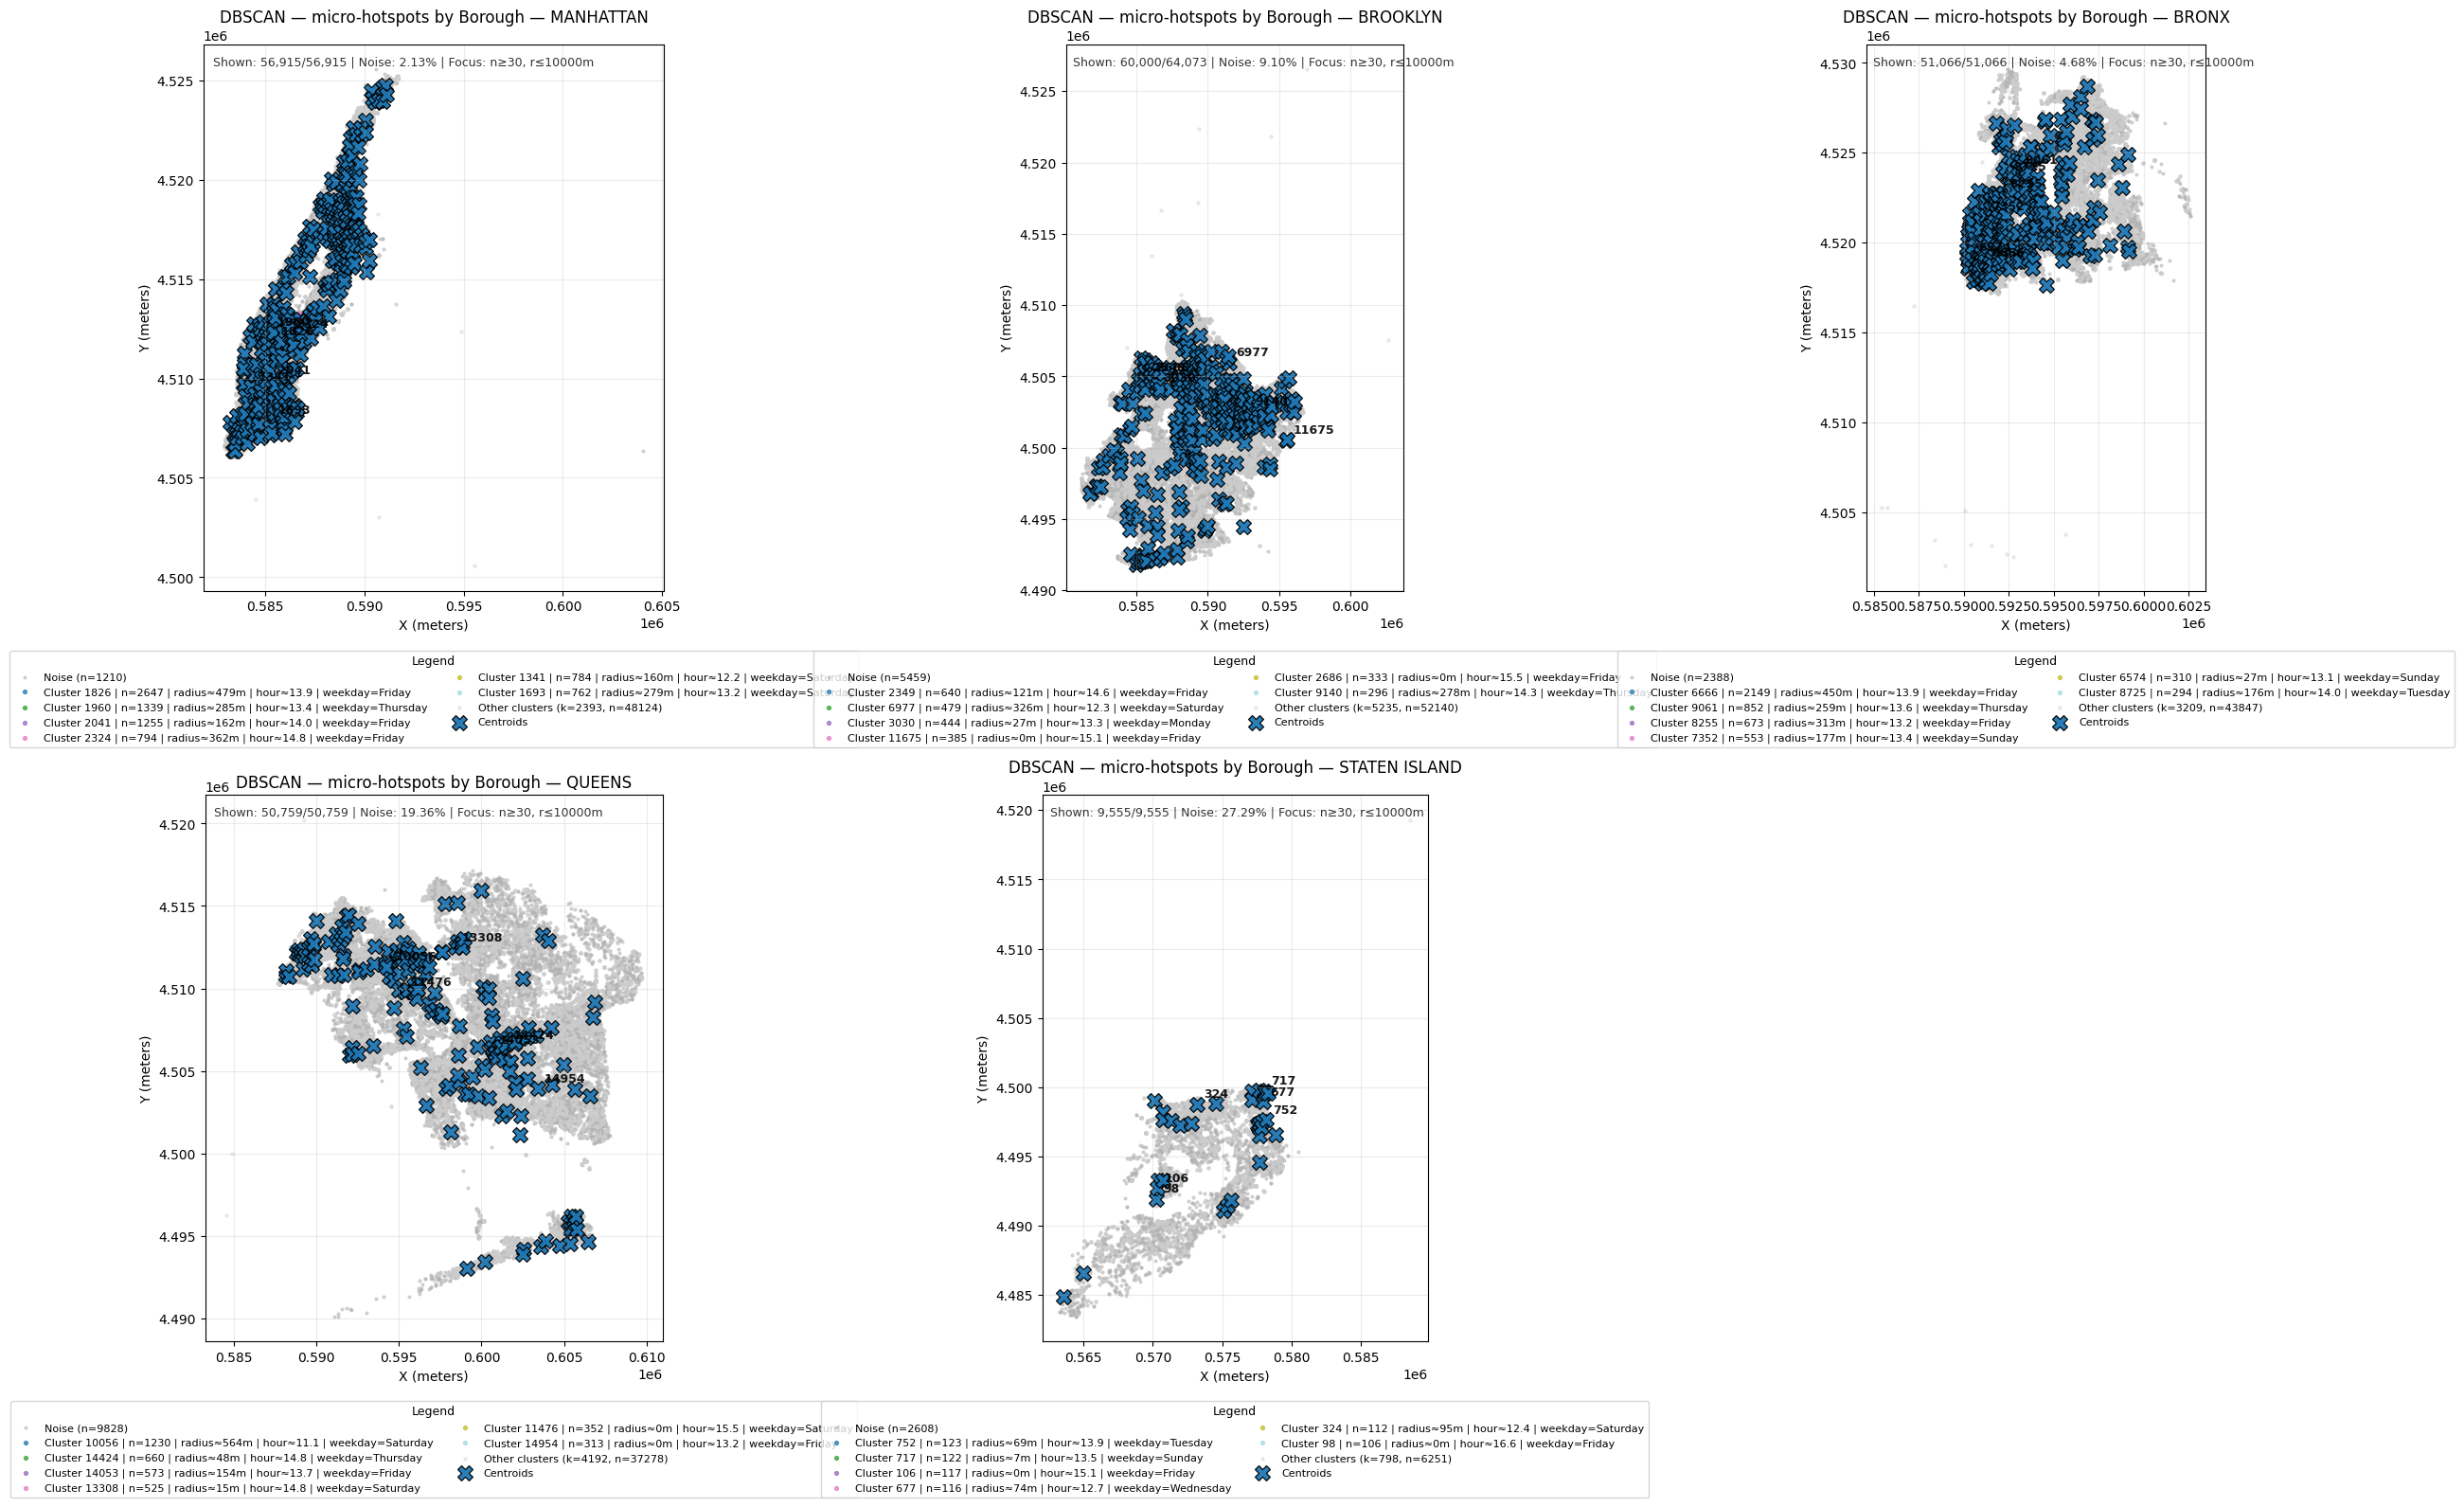

In [13]:
# --- Static visualization for micro-hotspots ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

_WEEKDAY_ORDER = ["MONDAY","TUESDAY","WEDNESDAY","THURSDAY","FRIDAY","SATURDAY","SUNDAY"]

def _median_radius_m_from_df(df):
    if df.empty:
        return np.nan
    c = df[["X_METERS","Y_METERS"]].mean().values
    d = np.linalg.norm(df[["X_METERS","Y_METERS"]].values - c, axis=1)
    return float(np.median(d)) if len(d) else np.nan

def _weekday_mode(series):
    wd = series.astype(str).str.upper()
    wd = wd.where(wd.isin(_WEEKDAY_ORDER), np.nan)
    mode = wd.mode()
    return mode.iloc[0].title() if not mode.empty else np.nan

def _legend_label(c, stats_row):
    parts = [f"Cluster {int(c)}", f"n={int(stats_row['n'])}"]
    if pd.notna(stats_row.get("median_radius_m", np.nan)):
        parts.append(f"radius≈{stats_row['median_radius_m']:.0f}m")
    if pd.notna(stats_row.get("hour_mean", np.nan)):
        parts.append(f"hour≈{stats_row['hour_mean']:.1f}")
    if isinstance(stats_row.get("weekday_mode", np.nan), str):
        parts.append(f"weekday={stats_row['weekday_mode']}")
    return " | ".join(parts)

def plot_clusters(
    df_labeled: pd.DataFrame,
    title: str = "DBSCAN (spatio-temporal micro-hotspots) — meter space",
    sample_max: int = 120_000,
    top_k_legend: int = 10,
    focus_only: bool = True,
    min_points: int = 30,          # keep clusters with at least N points (actionable)
    max_radius_m: float = 800.0,   # keep clusters with median radius <= max_radius_m (micro-hotspots)
    show_centroids: bool = True,
    annotate_topk: bool = True
):
    # Safety
    needed = {"X_METERS","Y_METERS","cluster"}
    missing = needed - set(df_labeled.columns)
    if missing:
        raise ValueError(f"df_labeled is missing columns: {missing}")

    # Compute per-cluster stats from FULL data (not the sample)
    grp = df_labeled[df_labeled["cluster"] != -1].groupby("cluster", sort=True)
    stats = pd.DataFrame({
        "n": grp.size(),
        "centroid_x_m": grp["X_METERS"].mean(),
        "centroid_y_m": grp["Y_METERS"].mean(),
        "median_radius_m": grp.apply(_median_radius_m_from_df)
    })
    # temporal summaries if available
    if "HOUR" in df_labeled.columns:
        stats["hour_mean"] = grp["HOUR"].mean()
    if "WEEKDAY" in df_labeled.columns:
        stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

    # Focus filter for micro-hotspots
    if focus_only:
        mask = (stats["n"] >= min_points) & (stats["median_radius_m"] <= max_radius_m)
        stats = stats[mask]

    # If nothing passes the focus filter, fall back to top by size
    if stats.empty:
        stats = pd.DataFrame({
            "n": grp.size(),
            "centroid_x_m": grp["X_METERS"].mean(),
            "centroid_y_m": grp["Y_METERS"].mean(),
            "median_radius_m": grp.apply(_median_radius_m_from_df)
        }).sort_values("n", ascending=False).head(top_k_legend)

        if "HOUR" in df_labeled.columns:
            stats["hour_mean"] = grp["HOUR"].mean()
        if "WEEKDAY" in df_labeled.columns:
            stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

    # Determine which clusters to highlight in legend
    highlight = stats.sort_values(["n", "median_radius_m"], ascending=[False, True]).head(top_k_legend)
    top_clusters = list(highlight.index)

    # Build plotting sample for speed
    plot_df = df_labeled if len(df_labeled) <= sample_max else df_labeled.sample(sample_max, random_state=42)

    # Counts / noise
    counts = plot_df["cluster"].value_counts(dropna=False)
    n_total = int(len(plot_df))
    n_noise = int(counts.get(-1, 0))
    noise_ratio = n_noise / max(n_total, 1)

    # Colors
    cmap = plt.cm.get_cmap("tab20", max(2, len(top_clusters)))
    color_top = {c: cmap(i) for i, c in enumerate(top_clusters)}
    color_noise = (0.7, 0.7, 0.7, 0.35)
    color_other = (0.80, 0.80, 0.80, 0.35)

    # Plot
    fig, ax = plt.subplots(figsize=(9, 9))

    # Noise
    if n_noise > 0:
        sdf = plot_df[plot_df["cluster"] == -1]
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=4, alpha=0.5, label=f"Noise (n={len(sdf)})", c=[color_noise])

    # Top clusters (descriptive legend)
    for c in top_clusters:
        sdf = plot_df[plot_df["cluster"] == c]
        label_txt = _legend_label(c, stats.loc[c])
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=8, alpha=0.7, c=[color_top[c]], label=label_txt)

    # Other clusters (shown subdued)
    others = [c for c in plot_df["cluster"].unique() if c not in top_clusters and c != -1]
    if len(others) > 0:
        sdf = plot_df[plot_df["cluster"].isin(others)]
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=5, alpha=0.35,
                   label=f"Other clusters (k={len(others)}, n={len(sdf)})", c=[color_other])

    # Centroids
    if show_centroids and not stats.empty:
        ax.scatter(
            stats["centroid_x_m"], stats["centroid_y_m"],
            s=130, marker="X", linewidth=0.9, edgecolor="black", alpha=0.95, label="Centroids"
        )
        if annotate_topk:
            ann = stats.loc[top_clusters]
            for cid, r in ann.iterrows():
                ax.annotate(f"{int(cid)}", (float(r["centroid_x_m"]), float(r["centroid_y_m"])),
                            xytext=(5,5), textcoords="offset points",
                            fontsize=9, weight="bold", alpha=0.9)

    # Titles & layout
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_aspect("equal")

    ax.text(0.02, 0.98,
            f"Shown: {len(plot_df):,}/{len(df_labeled):,} | Noise: {noise_ratio:.2%} | "
            f"Focus: n≥{min_points}, radius≤{int(max_radius_m)}m",
            transform=ax.transAxes, va="top", ha="left", fontsize=9, alpha=0.8)

    # Legend below plot
    leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08),
                    ncol=1 if len(top_clusters) <= 4 else 2, frameon=True, fontsize=9)
    if leg:
        leg.set_title("Legend", prop={"size": 10})

    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

def _auto_detect_zone_col(df: pd.DataFrame, fallback: str | None = None) -> str:
    candidates = ["BOROUGH", "Borough", "BORO_NM", "NEIGHBORHOOD", "NTA_NAME", "Precinct", "PRECINCT"]
    if fallback and fallback in df.columns:
        return fallback
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(
        f"Could not detect a zone column. "
        f"Pass zone_col explicitly (e.g., zone_col='BOROUGH'). "
        f"Available columns: {list(df.columns)[:20]}..."
    )

def plot_clusters_by_zone(
    df_labeled: pd.DataFrame,
    zone_col: str | None = None,
    zones: list[str] | None = None,     # subset like ["MANHATTAN","BROOKLYN"] if you want
    title: str = "DBSCAN — micro-hotspots by zone",
    sample_max_per_zone: int = 60_000,
    top_k_legend: int = 6,
    focus_only: bool = True,
    min_points: int = 30,
    max_radius_m: float = 800.0,
    show_centroids: bool = True,
    annotate_topk: bool = True,
    ncols: int = 3,                      # columns in the facet grid
):
    # --- Safety
    required = {"X_METERS", "Y_METERS", "cluster"}
    miss = required - set(df_labeled.columns)
    if miss:
        raise ValueError(f"df_labeled is missing columns: {miss}")
    
    # Detect zone column if not provided
    zone_col = _auto_detect_zone_col(df_labeled, zone_col)

    # Get zone list
    all_zones = [z for z in df_labeled[zone_col].dropna().unique().tolist()]
    # sort for consistency (strings first, then numbers)
    try:
        all_zones = sorted(all_zones, key=lambda x: (str(type(x)), x))
    except Exception:
        all_zones = sorted(all_zones, key=str)
    zone_list = zones if zones is not None else all_zones
    if len(zone_list) == 0:
        raise ValueError(f"No zones found in column '{zone_col}'.")

    # Prepare facet grid
    n = len(zone_list)
    ncols = max(1, ncols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8.5*ncols, 8*nrows))
    axes = np.atleast_1d(axes).reshape(nrows, ncols)

    # --- Plot each zone
    for idx, zone in enumerate(zone_list):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        sub = df_labeled[df_labeled[zone_col] == zone].copy()

        # If empty or only noise, just annotate
        if sub.empty or (sub["cluster"].nunique() == 1 and sub["cluster"].unique()[0] == -1):
            ax.set_title(f"{zone} — no clusters", fontsize=12)
            ax.set_xlabel("X (meters)"); ax.set_ylabel("Y (meters)"); ax.set_aspect("equal")
            ax.grid(True, alpha=0.25)
            continue

        # Compute per-cluster stats within this zone
        grp = sub[sub["cluster"] != -1].groupby("cluster", sort=True)
        stats = pd.DataFrame({
            "n": grp.size(),
            "centroid_x_m": grp["X_METERS"].mean(),
            "centroid_y_m": grp["Y_METERS"].mean(),
            "median_radius_m": grp.apply(_median_radius_m_from_df)
        })
        if "HOUR" in sub.columns:
            stats["hour_mean"] = grp["HOUR"].mean()
        if "WEEKDAY" in sub.columns:
            stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

        # Focus filter (actionable micro-hotspots)
        if focus_only and not stats.empty:
            mask = (stats["n"] >= min_points) & (stats["median_radius_m"] <= max_radius_m)
            stats = stats[mask]

        # If still empty, fall back to top by size
        if stats.empty:
            stats = pd.DataFrame({
                "n": grp.size(),
                "centroid_x_m": grp["X_METERS"].mean(),
                "centroid_y_m": grp["Y_METERS"].mean(),
                "median_radius_m": grp.apply(_median_radius_m_from_df)
            }).sort_values("n", ascending=False).head(top_k_legend)
            if "HOUR" in sub.columns:
                stats["hour_mean"] = grp["HOUR"].mean()
            if "WEEKDAY" in sub.columns:
                stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

        # Sort and pick Top-K for legend
        highlight = stats.sort_values(["n", "median_radius_m"], ascending=[False, True]).head(top_k_legend)
        top_clusters = list(highlight.index)

        # Sample points for speed
        plot_df = sub if len(sub) <= sample_max_per_zone else sub.sample(sample_max_per_zone, random_state=42)

        # Counts / noise
        counts = plot_df["cluster"].value_counts(dropna=False)
        n_total = int(len(plot_df))
        n_noise = int(counts.get(-1, 0))
        noise_ratio = n_noise / max(n_total, 1)

        # Colors for this zone
        cmap = plt.cm.get_cmap("tab20", max(2, len(top_clusters)))
        color_top = {cl: cmap(i) for i, cl in enumerate(top_clusters)}
        color_noise = (0.7, 0.7, 0.7, 0.35)
        color_other = (0.80, 0.80, 0.80, 0.35)

        # Plot noise
        if n_noise > 0:
            sdf = plot_df[plot_df["cluster"] == -1]
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=4, alpha=0.5,
                       label=f"Noise (n={len(sdf)})", c=[color_noise])

        # Plot top clusters with descriptive legend
        for cl in top_clusters:
            sdf = plot_df[plot_df["cluster"] == cl]
            label_txt = _legend_label(cl, stats.loc[cl])
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=8, alpha=0.7,
                       c=[color_top[cl]], label=label_txt)

        # Other clusters (subdued)
        others = [cl for cl in plot_df["cluster"].unique() if cl not in top_clusters and cl != -1]
        if len(others) > 0:
            sdf = plot_df[plot_df["cluster"].isin(others)]
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=5, alpha=0.35,
                       label=f"Other clusters (k={len(others)}, n={len(sdf)})", c=[color_other])

        # Centroids overlay
        if show_centroids and not stats.empty:
            ax.scatter(stats["centroid_x_m"], stats["centroid_y_m"],
                       s=130, marker="X", linewidth=0.9,
                       edgecolor="black", alpha=0.95, label="Centroids")
            if annotate_topk:
                ann = stats.loc[top_clusters]
                for cid, rrow in ann.iterrows():
                    ax.annotate(f"{int(cid)}", (float(rrow["centroid_x_m"]), float(rrow["centroid_y_m"])),
                                xytext=(5,5), textcoords="offset points",
                                fontsize=9, weight="bold", alpha=0.9)

        # Titles, labels
        ax.set_title(f"{title} — {zone}", fontsize=12)
        ax.set_xlabel("X (meters)"); ax.set_ylabel("Y (meters)")
        ax.set_aspect("equal")
        ax.text(0.02, 0.98,
                f"Shown: {len(plot_df):,}/{len(sub):,} | Noise: {noise_ratio:.2%} | "
                f"Focus: n≥{min_points}, r≤{int(max_radius_m)}m",
                transform=ax.transAxes, va="top", ha="left", fontsize=9, alpha=0.8)
        ax.grid(True, alpha=0.25)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(6, 6))
        # Legend under each axis
        leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.10),
                        ncol=1 if len(top_clusters) <= 4 else 2, frameon=True, fontsize=8)
        if leg:
            leg.set_title("Legend", prop={"size": 9})

    # Remove empty axes if grid not full
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


plot_clusters_by_zone(
    df_labeled,
    title="DBSCAN — micro-hotspots by Borough",
    top_k_legend=6,
    focus_only=True,
    zones=["MANHATTAN", "BROOKLYN", "BRONX", "QUEENS", "STATEN ISLAND"],
    min_points=30,
    max_radius_m=10000.0,
    ncols=3
)

## 4. Operational hotspots


In [14]:
# --- Operational Hotspots per Shift (00–08, 08–16, 16–24) --------------------

import numpy as np
import pandas as pd
from sklearn.base import clone
from shapely.geometry import Point, MultiPoint, mapping
from shapely.ops import transform as shp_transform
from pyproj import Transformer

# 0) Define shifts (half-open intervals)
SHIFTS = [
    ("00-08", 0, 8),
    ("08-16", 8, 16),
    ("16-24", 16, 24),
]

# 1) Utility: get XY meter columns from a fitted preprocessor
def _xy_indices(pre_fitted):
    names = list(pre_fitted.get_feature_names_out())
    ix_x = names.index("X_METERS") if "X_METERS" in names else names.index("spatial__X_METERS")
    ix_y = names.index("Y_METERS") if "Y_METERS" in names else names.index("spatial__Y_METERS")
    return ix_x, ix_y

# 2) Utility: project Shapely geom from projected CRS to WGS84
def _geom_to_wgs84(geom_m, crs_proj="EPSG:32618"):
    t = Transformer.from_crs(crs_proj, "EPSG:4326", always_xy=True)
    return shp_transform(lambda x, y, z=None: t.transform(x, y), geom_m)

# 3) Build hotspot polygons for each shift
def build_shift_hotspots(
    df_all,
    pipe,
    best_params,
    shifts=SHIFTS,
    buffer_m=120,                # buffer to make patrolable polygons
    min_cluster_points=5,        # below this: buffered centroid instead of hull
    crs_proj="EPSG:32618",       # must match your SpatialProjectionTransformer
    use_temporal_slice=True,     # True: slice by shift (recommended)
    ranking_metric="density"     # "density" (points/km^2) or "count"
):
    """
    Returns:
      hotspots_df: per-cluster summary (one row per (shift, cluster_id))
      polygons_geojson: list of dicts {shift, cluster, geojson}
    """
    # Prepare outputs
    rows = []
    polygons_geojson = []

    for shift_name, h0, h1 in shifts:
        # 3.1 Slice data for the shift (optional if you keep temporal weighting)
        df_s = df_all[(df_all["HOUR"] >= h0) & (df_all["HOUR"] < h1)] if use_temporal_slice else df_all
        if df_s.empty:
            continue

        # 3.2 Fit DBSCAN on the slice with the best params
        model = clone(pipe).set_params(**best_params).fit(df_s)
        labels = model.named_steps["cluster"].labels_

        # 3.3 Extract XY in meters from fitted preprocessor
        X_all = np.asarray(model.named_steps["pre"].transform(df_s))
        ix_x, ix_y = _xy_indices(model.named_steps["pre"])
        XY = X_all[:, [ix_x, ix_y]]

        # 3.4 Build polygons cluster-by-cluster
        unique = np.unique(labels)
        unique = unique[unique != -1]  # skip noise
        if unique.size == 0:
            continue

        # Try to read CRS from the fitted spatial transformer (fallback to arg)
        try:
            crs_proj_fit = model.named_steps["pre"].named_transformers_["spatial"].crs
        except Exception:
            crs_proj_fit = crs_proj

        for c in sorted(unique):
            pts = XY[labels == c]
            npts = int(len(pts))
            if npts == 0:
                continue

            # centroid in meters
            center = pts.mean(axis=0)

            # polygon in meters: convex hull if enough points, else buffered centroid
            if npts >= max(3, min_cluster_points):
                hull = MultiPoint([Point(x, y) for x, y in pts]).convex_hull
                geom_m = hull.buffer(buffer_m)  # grow to patrolable area
            else:
                geom_m = Point(center[0], center[1]).buffer(buffer_m)

            area_m2 = float(geom_m.area)
            centroid_m = geom_m.centroid

            # density per km^2 (simple: points / km^2)
            density_per_km2 = npts / max(area_m2, 1e-9) * 1e6

            # WGS84 centroid and polygon (for maps/exports)
            geom_wgs = _geom_to_wgs84(geom_m, crs_proj=crs_proj_fit)
            centroid_lon, centroid_lat = list(geom_wgs.centroid.coords)[0]

            rows.append({
                "shift": shift_name,
                "cluster": int(c),
                "n_points": npts,
                "area_m2": area_m2,
                "density_per_km2": density_per_km2,
                "centroid_lat": centroid_lat,
                "centroid_lon": centroid_lon,
            })
            polygons_geojson.append({
                "shift": shift_name,
                "cluster": int(c),
                "geojson": {
                    "type": "Feature",
                    "properties": {
                        "shift": shift_name,
                        "cluster": int(c),
                        "n_points": npts,
                        "density_per_km2": density_per_km2
                    },
                    "geometry": mapping(geom_wgs)
                }
            })

    hotspots_df = pd.DataFrame(rows).sort_values(
        by=["shift", "density_per_km2" if ranking_metric=="density" else "n_points"],
        ascending=[True, False]
    ).reset_index(drop=True)

    return hotspots_df, polygons_geojson

# 4) Rank Top-N hotspots per shift (for deployment)
def rank_top_hotspots(hotspots_df, top_n=5, by="density_per_km2"):
    top_rows = []
    for s in hotspots_df["shift"].unique():
        sub = hotspots_df[hotspots_df["shift"] == s].nlargest(top_n, by)
        top_rows.append(sub)
    return pd.concat(top_rows).reset_index(drop=True)

# ------------------------ USAGE EXAMPLE ---------------------------------------
# Choose data: full dataset after you're happy with params
DF_DEPLOY = df_spatial  # or DF_RUN if you want to test on the sample

if 'best_params' not in locals() or best_params is None:
    if 'res_df' in locals() and not res_df.empty:
        r0 = res_df.iloc[0]
        best_params = {
            "cluster__eps": float(r0["eps"]),
            "cluster__min_samples": int(r0["min_samples"]),
            "pre__temporal__weight__kw_args": {"w": float(r0["temporal_weight"])}
        }
    else:
        raise RuntimeError("best_params not found. Run the sweep first.")

hotspots_df, polygons_geojson = build_shift_hotspots(
    DF_DEPLOY, pipe, best_params,
    shifts=SHIFTS,
    buffer_m=120,
    min_cluster_points=5,
    crs_proj="EPSG:32618",
    use_temporal_slice=True,
    ranking_metric="density"
)

print("Hotspot summary (top rows):")
display(hotspots_df.head(15))

# Example: pick Top-5 per shift by density
topN = rank_top_hotspots(hotspots_df, top_n=5, by="density_per_km2")
print("Top-N hotspots per shift:")
display(topN)
# polygons_geojson is ready for map export (GeoJSON Feature objects)


Hotspot summary (top rows):


,shift,cluster,n_points,area_m2,density_per_km2,centroid_lat,centroid_lon
0,00-08,1925,51,45380.409848,1123.832953,40.789597,-73.929985
1,00-08,3436,68,64223.882594,1058.796156,40.756587,-73.875604
2,00-08,653,46,45166.298264,1018.458492,40.765024,-73.984836
3,00-08,4245,58,57609.374359,1006.780592,40.679887,-73.776515
4,00-08,3471,55,55383.616464,993.073467,40.743567,-73.874229
5,00-08,4121,44,45383.275991,969.520138,40.699799,-73.807365
6,00-08,2196,49,50787.609269,964.802256,40.837824,-73.919577
7,00-08,2046,57,65874.515705,865.281504,40.810054,-73.925144
8,00-08,1328,39,49262.297855,791.680488,40.648857,-73.950917
9,00-08,3095,311,396781.775251,783.806161,40.746780,-73.888143


Top-N hotspots per shift:


,shift,cluster,n_points,area_m2,density_per_km2,centroid_lat,centroid_lon
0,00-08,1925,51,45380.409848,1123.832953,40.789597,-73.929985
1,00-08,3436,68,64223.882594,1058.796156,40.756587,-73.875604
2,00-08,653,46,45166.298264,1018.458492,40.765024,-73.984836
3,00-08,4245,58,57609.374359,1006.780592,40.679887,-73.776515
4,00-08,3471,55,55383.616464,993.073467,40.743567,-73.874229
5,08-16,1099,317,45406.944380,6981.310994,40.750428,-73.989281
6,08-16,791,244,45409.491198,5373.326007,40.724838,-73.997279
7,08-16,2301,212,45406.946316,4668.889172,40.779164,-73.954785
8,08-16,6300,198,45166.298264,4383.799594,40.650466,-73.869986
9,08-16,2763,176,45409.488331,3875.841954,40.808377,-73.946905


In [15]:
# --- Visualize hotspot GeoJSONs by shift (Folium) -----------------------------

import folium
from folium import FeatureGroup, GeoJson
from statistics import mean

if not polygons_geojson:
    raise ValueError("polygons_geojson is empty. Build it before mapping.")

# ---- Compute map center (prefer centroids from hotspots_df if available) -----
if 'hotspots_df' in locals() and hotspots_df is not None and not hotspots_df.empty:
    center_lat = float(hotspots_df["centroid_lat"].mean())
    center_lon = float(hotspots_df["centroid_lon"].mean())
else:
    # fallback: mean of all polygon coordinates
    lats, lons = [], []
    for item in polygons_geojson:
        geom = item["geojson"]["geometry"]
        t = geom["type"]
        if t == "Polygon":
            for ring in geom["coordinates"]:
                for lon, lat in ring:
                    lats.append(lat); lons.append(lon)
        elif t == "MultiPolygon":
            for poly in geom["coordinates"]:
                for ring in poly:
                    for lon, lat in ring:
                        lats.append(lat); lons.append(lon)
    center_lat = mean(lats); center_lon = mean(lons)

# ---- Base map ---------------------------------------------------------------
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="CartoDB positron")

# ---- Per-shift layers with colors ------------------------------------------
shifts = sorted({p["shift"] for p in polygons_geojson})
palette = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
color_map = {s: palette[i % len(palette)] for i, s in enumerate(shifts)}

# Optional centroid lookup from hotspots_df
centroid_lookup = {}
if 'hotspots_df' in locals() and hotspots_df is not None and not hotspots_df.empty:
    for _, r in hotspots_df.iterrows():
        centroid_lookup[(r["shift"], int(r["cluster"]))] = (float(r["centroid_lat"]), float(r["centroid_lon"]))

for s in shifts:
    fg = FeatureGroup(name=f"Shift {s}", show=True)

    for item in (p for p in polygons_geojson if p["shift"] == s):
        feat = item["geojson"]
        props = feat.get("properties", {})
        cluster = props.get("cluster", item.get("cluster", "?"))
        npts = props.get("n_points", "?")
        dens = props.get("density_per_km2", None)

        # style: color by shift
        color = color_map[s]
        gj = GeoJson(
            data=feat,
            style_function=lambda x, col=color: {
                "fillColor": col, "color": col, "weight": 2, "fillOpacity": 0.35
            },
            highlight_function=lambda x: {"weight": 3, "fillOpacity": 0.55},
        )

        # popup with basic stats
        if isinstance(dens, (int, float)):
            info = f"<b>Shift:</b> {s}<br><b>Cluster:</b> {cluster}<br><b>Events:</b> {npts}<br><b>Density:</b> {dens:.1f}/km²"
        else:
            info = f"<b>Shift:</b> {s}<br><b>Cluster:</b> {cluster}<br><b>Events:</b> {npts}"
        gj.add_child(folium.Popup(folium.IFrame(info, width=220, height=110), max_width=260))
        gj.add_to(fg)

        # optional centroid marker if available
        key = (s, int(cluster)) if isinstance(cluster, (int, float, str)) and str(cluster).isdigit() else None
        if key and key in centroid_lookup:
            lat, lon = centroid_lookup[key]
            folium.CircleMarker(
                location=[lat, lon],
                radius=4,
                color=color, fill=True, fill_opacity=1.0,
                tooltip=f"Centroid — shift {s}, cluster {cluster}"
            ).add_to(fg)

    fg.add_to(m)

# Layer control and display
folium.LayerControl(collapsed=False).add_to(m)
m  # In Jupyter this renders the interactive map

m.save("hotspots_map.html")
